In [234]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests

In [216]:
test_df = pd.read_csv('data/test_data.tsv', sep='\t')
train_df = pd.read_csv('data/train_data.tsv', sep='\t')
sonnia_df = pd.read_csv('data/sonnia_data.tsv', sep='\t')
pwm_df = pd.read_csv('data/pwm_data.tsv', sep='\t')
vae_df = pd.read_csv('data/vae_data.tsv', sep='\t')

In [217]:
test_seq = test_df.loc[:, 'sequence_aa'].tolist()
train_seq = train_df.loc[:, 'sequence_aa'].tolist()
sonnia_seq = sonnia_df.loc[:, 'sequence_aa'].tolist()
pwm_seq = pwm_df.loc[:, 'sequence_aa'].tolist()
vae_seq = vae_df.loc[:, 'sequence_aa'].tolist()

In [218]:
def get_kmer_counts(sequences, k):
    kmer_counts = {}
    for seq in sequences:
        for i in range(len(seq) - k + 1):
            kmer = seq[i:i+k]
            kmer_counts[kmer] = kmer_counts.get(kmer, 0) + 1
    return kmer_counts

Fisher Exact Test

In [279]:
def find_significantly_different_kmers(dataset1, name1, dataset2, name2, k = 3):
    dataset1_kmer_counts = get_kmer_counts(dataset1, k)
    dataset2_kmer_counts = get_kmer_counts(dataset2, k)
    all_kmers_comparison = set(dataset1_kmer_counts.keys()).union(set(dataset2_kmer_counts.keys()))
    
    data_comparison = []
    for kmer in all_kmers_comparison:
        dataset1_count = dataset1_kmer_counts.get(kmer, 0)
        dataset2_count = dataset2_kmer_counts.get(kmer, 0)
        dataset1_freq = dataset1_count / sum(dataset1_kmer_counts.values())
        dataset2_freq = dataset2_count / sum(dataset2_kmer_counts.values())
        data_comparison.append([kmer, dataset1_count, dataset2_count, dataset1_freq, dataset2_freq])
    kmer_comparison_df = pd.DataFrame(data_comparison, columns=['kmer', name1 + '_count', name2 + '_count', name1 + '_freq', name2 + '_freq'])
    
    p_values = []
    for _, row in kmer_comparison_df.iterrows():
        dataset1_count = row[name1 + '_count']
        dataset2_count = row[name2 + '_count']
        total_dataset1 = sum(kmer_comparison_df[name1 + '_count'])
        total_dataset2 = sum(kmer_comparison_df[name2 + '_count'])
        
        contingency_table = [[dataset1_count, total_dataset1 - dataset1_count], [dataset2_count, total_dataset2 - dataset2_count]]
        
        _, p_value = fisher_exact(contingency_table)
        p_values.append(p_value)
        
    adjusted_p_values = multipletests(p_values, method='fdr_bh')[1] 
    
    kmer_comparison_df['p_value'] = p_values
    kmer_comparison_df['adjusted_p_value'] = adjusted_p_values
    
    significant_kmers = kmer_comparison_df[kmer_comparison_df['adjusted_p_value'] < 0.05]
    
    # Display the significant k-mers with adjusted p-values
    #print("Significant k-mers after BH correction:")
    #print(significant_kmers[['kmer', name1 + '_count', name2 + '_count', 'p_value', 'adjusted_p_value']])
    return kmer_comparison_df, significant_kmers

In [280]:
sonnia_train_df, sonnia_train_significant = find_significantly_different_kmers(train_seq, "train", sonnia_seq, "sonnia")
sonnia_test_df, sonnia_test_significant = find_significantly_different_kmers(test_seq, "test", sonnia_seq, "sonnia")
pwm_train_df, pwm_train_significant = find_significantly_different_kmers(train_seq, "train", pwm_seq, "pwm")
pwm_test_df, pwm_test_significant = find_significantly_different_kmers(test_seq, "test", pwm_seq, "pwm")
vae_train_df, vae_train_significant = find_significantly_different_kmers(train_seq, "train", vae_seq, "vae")
vae_test_df, vae_test_significant = find_significantly_different_kmers(test_seq, "test", vae_seq, "vae")

In [281]:
methods = ["sonnia", "pwm", "vae"]
train_counts = [len(sonnia_train_significant), len(pwm_train_significant), len(vae_train_significant)]
test_counts = [len(sonnia_test_significant), len(pwm_test_significant), len(vae_test_significant)]  # hypothetical counts

significant_kmer_counts = {
    "method": methods * 2,
    "set_type": ["train"] * len(methods) + ["test"] * len(methods),
    "significant_kmer_count": train_counts + test_counts
}
significant_kmer_counts_df = pd.DataFrame(significant_kmer_counts)

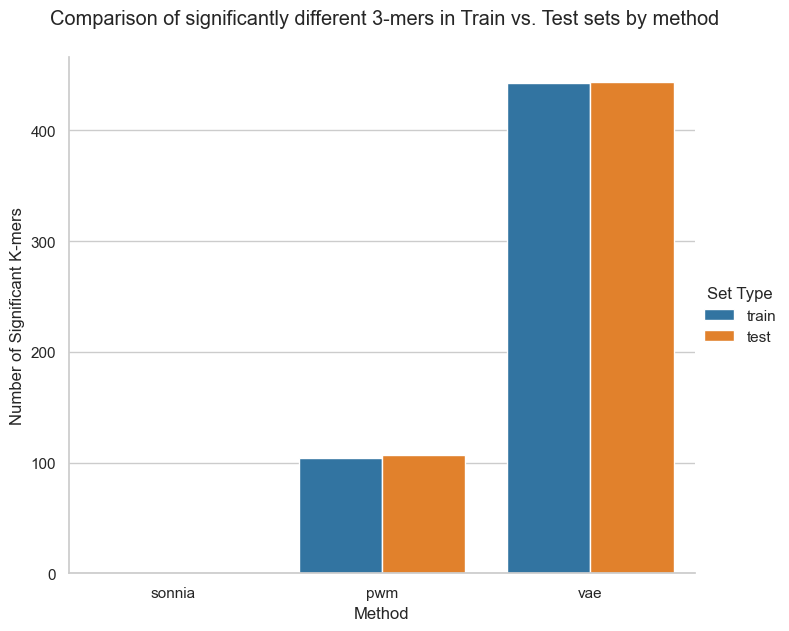

In [282]:
custom_colors = ["#1f77b4", "#ff7f0e"]

sns.set(style="whitegrid")
g = sns.catplot(
    data=significant_kmer_counts_df,
    x="method",
    y="significant_kmer_count",
    hue="set_type",
    kind="bar",
    palette=custom_colors,
    height=6,
    aspect=1.2
)

g.set_axis_labels("Method", "Number of Significant K-mers")
g.fig.suptitle("Comparison of significantly different 3-mers in Train vs. Test sets by method", y=1.05)  # Title with spacing
g._legend.set_title("Set Type")
plt.show()

In [317]:
import plotly.express as px
import numpy as np

def pseudo_log_transform(x, threshold=1e-3):
    return np.sign(x) * np.log1p(np.abs(x / threshold))

pwm_train_df['pseudo_train_freq'] = pseudo_log_transform(pwm_train_df['train_freq'])
pwm_train_df['pseudo_pwm_freq'] = pseudo_log_transform(pwm_train_df['pwm_freq'])
pwm_train_df['significance'] = np.where(pwm_train_df['adjusted_p_value'] < 0.05, True, False)

significant_count = pwm_train_df['significance'].value_counts().get(True, 0)

fig = px.scatter(
    pwm_train_df,
    x="pseudo_train_freq",
    y="pseudo_pwm_freq",
    hover_name="kmer",  
    color="significance",
    labels={"pseudo_train_freq": "Pseudo-log Train Frequency", "pseudo_pwm_freq": "Pseudo-log pwm Frequency"},
    title=f"Scatter plot of train vs. pwm k-mer frequencies ({significant_count} significantly different 3-mers)",
    width=1000,
    height=1000,
    opacity=0.5
)

fig.update_layout(
    xaxis_title="Train Frequency (Pseudo-log Scale)",
    yaxis_title="pwm Frequency (Pseudo-log Scale)"
)

fig.show()